In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Start
repo - https://github.com/peteryuX/retinaface-tf2

Dataset - http://shuoyang1213.me/WIDERFACE/

Training dataset download link - https://drive.google.com/file/d/15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M/view

Validation dataset download link - https://drive.google.com/file/d/1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q/view

RetinaFace official annotations - http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip

In [3]:
import os
import cv2
import json
import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from google_drive_downloader import GoogleDriveDownloader as gdd

# Configuration

In [4]:
cfg = {
'batch_size': 8,
'input_size': 640,
'backbone_type': 'MobileNetV2',  # 'ResNet50', 'MobileNetV2'
'sub_name': 'retinaface_mbv2',

# training dataset
'dataset_path': '/content/drive/MyDrive/RetinaFace/widerface_train_bin_onlybbox.tfrecord',
'dataset_len': 12880,  # number of training samples
'using_bin': True,            #using binary or not
'using_flip': False,
'using_distort': False,

# testing dataset
'testing_dataset_path': './data/widerface/val',

# network
'out_channel': 64,

# anchor setting
'min_sizes': [[16, 32], [64, 128], [256, 512]],
'steps': [8, 16, 32],
'match_thresh': 0.45,
'ignore_thresh': 0.3,
'variances': [0.1, 0.2],
'clip': False,

# training setting
'epoch': 1,
'init_lr': float(1e-2),
'lr_decay_epoch': [50, 68],
'lr_rate': 0.1,
'warmup_epoch': 5,
'min_lr': float(1e-3),

'weights_decay': float(5e-4),
'momentum': 0.9,

'pretrain': True,

'save_steps': 1000
}

# Datasets

## Priors

In [5]:
import math
import tensorflow as tf
import numpy as np
from itertools import product as product


###############################################################################
#   Tensorflow / Numpy Priors                                                 #
###############################################################################
def prior_box(image_sizes, min_sizes, steps, clip=False):
    """prior box"""
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps]

    anchors = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                anchors += [cx, cy, s_kx, s_ky]

    output = np.asarray(anchors).reshape([-1, 4])

    if clip:
        output = np.clip(output, 0, 1)

    return output


def prior_box_tf(image_sizes, min_sizes, steps, clip=False):
    """prior box"""
    image_sizes = tf.cast(tf.convert_to_tensor(image_sizes), tf.float32)
    feature_maps = tf.math.ceil(
        tf.reshape(image_sizes, [1, 2]) /
        tf.reshape(tf.cast(steps, tf.float32), [-1, 1]))

    anchors = []
    for k in range(len(min_sizes)):
        grid_x, grid_y = _meshgrid_tf(tf.range(feature_maps[k][1]),
                                      tf.range(feature_maps[k][0]))
        cx = (grid_x + 0.5) * steps[k] / image_sizes[1]
        cy = (grid_y + 0.5) * steps[k] / image_sizes[0]
        cxcy = tf.stack([cx, cy], axis=-1)
        cxcy = tf.reshape(cxcy, [-1, 2])
        cxcy = tf.repeat(cxcy, repeats=tf.shape(min_sizes[k])[0], axis=0)

        sx = min_sizes[k] / image_sizes[1]
        sy = min_sizes[k] / image_sizes[0]
        sxsy = tf.stack([sx, sy], 1)
        sxsy = tf.repeat(sxsy[tf.newaxis],
                         repeats=tf.shape(grid_x)[0] * tf.shape(grid_x)[1],
                         axis=0)
        sxsy = tf.reshape(sxsy, [-1, 2])

        anchors.append(tf.concat([cxcy, sxsy], 1))

    output = tf.concat(anchors, axis=0)

    if clip:
        output = tf.clip_by_value(output, 0, 1)

    return output

def _meshgrid_tf(x, y):
    """ workaround solution of the tf.meshgrid() issue:
        https://github.com/tensorflow/tensorflow/issues/34470"""
    grid_shape = [tf.shape(y)[0], tf.shape(x)[0]]
    grid_x = tf.broadcast_to(tf.reshape(x, [1, -1]), grid_shape)
    grid_y = tf.broadcast_to(tf.reshape(y, [-1, 1]), grid_shape)
    return grid_x, grid_y


## Encoding

In [6]:
def _encode_bbox(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth
    boxes we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 4].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded boxes (tensor), Shape: [num_priors, 4]
    """

    # dist b/t match center and prior's center
    g_cxcy = (matched[:, :2] + matched[:, 2:]) / 2 - priors[:, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, 2:])
    # match wh / prior wh
    g_wh = (matched[:, 2:] - matched[:, :2]) / priors[:, 2:]
    g_wh = tf.math.log(g_wh) / variances[1]
    # return target for smooth_l1_loss
    return tf.concat([g_cxcy, g_wh], 1)  # [num_priors,4]


def _encode_landm(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth
    boxes we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 10].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded landm (tensor), Shape: [num_priors, 10]
    """

    # dist b/t match center and prior's center
    matched = tf.reshape(matched, [tf.shape(matched)[0], 5, 2])
    priors = tf.broadcast_to(
        tf.expand_dims(priors, 1), [tf.shape(matched)[0], 5, 4])
    g_cxcy = matched[:, :, :2] - priors[:, :, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, :, 2:])
    # g_cxcy /= priors[:, :, 2:]
    g_cxcy = tf.reshape(g_cxcy, [tf.shape(g_cxcy)[0], -1])
    # return target for smooth_l1_loss
    return g_cxcy


def _point_form(boxes):
    """ Convert prior_boxes to (xmin, ymin, xmax, ymax)
    representation for comparison to point form ground truth data.
    Args:
        boxes: (tensor) center-size default boxes from priorbox layers.
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return tf.concat((boxes[:, :2] - boxes[:, 2:] / 2,
                      boxes[:, :2] + boxes[:, 2:] / 2), axis=1)


def _intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2]:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.maximum((max_xy - min_xy), tf.zeros_like(max_xy - min_xy))
    return inter[:, :, 0] * inter[:, :, 1]


def _jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]




In [7]:
###############################################################################
#   Tensorflow Encoding                                                       #
###############################################################################
def encode_tf(labels, priors, match_thresh, ignore_thresh,
              variances=[0.1, 0.2]):
    """tensorflow encoding"""
    assert ignore_thresh <= match_thresh
    priors = tf.cast(priors, tf.float32)
    bbox = labels[:, :4]
    #landm = labels[:, 4:-1]
    landm = tf.concat([labels[:, :],labels[:, :]], axis=1)         #dummy value
    landm_valid = labels[:, -1]  # 1: with landm, 0: w/o landm.

    # jaccard index
    overlaps = _jaccard(bbox, _point_form(priors))

    # (Bipartite Matching)
    # [num_objects] best prior for each ground truth
    best_prior_overlap, best_prior_idx = tf.math.top_k(overlaps, k=1)
    best_prior_overlap = best_prior_overlap[:, 0]
    best_prior_idx = best_prior_idx[:, 0]

    # [num_priors] best ground truth for each prior
    overlaps_t = tf.transpose(overlaps)
    best_truth_overlap, best_truth_idx = tf.math.top_k(overlaps_t, k=1)
    best_truth_overlap = best_truth_overlap[:, 0]
    best_truth_idx = best_truth_idx[:, 0]

    # ensure best prior
    def _loop_body(i, bt_idx, bt_overlap):
        bp_mask = tf.one_hot(best_prior_idx[i], tf.shape(bt_idx)[0])
        bp_mask_int = tf.cast(bp_mask, tf.int32)
        new_bt_idx = bt_idx * (1 - bp_mask_int) + bp_mask_int * i
        bp_mask_float = tf.cast(bp_mask, tf.float32)
        new_bt_overlap = bt_overlap * (1 - bp_mask_float) + bp_mask_float * 2
        return tf.cond(best_prior_overlap[i] > match_thresh,
                       lambda: (i + 1, new_bt_idx, new_bt_overlap),
                       lambda: (i + 1, bt_idx, bt_overlap))
    _, best_truth_idx, best_truth_overlap = tf.while_loop(
        lambda i, bt_idx, bt_overlap: tf.less(i, tf.shape(best_prior_idx)[0]),
        _loop_body, [tf.constant(0), best_truth_idx, best_truth_overlap])

    matches_bbox = tf.gather(bbox, best_truth_idx)  # [num_priors, 4]
    matches_landm = tf.gather(landm, best_truth_idx)  # [num_priors, 10]
    matches_landm_v = tf.gather(landm_valid, best_truth_idx)  # [num_priors]

    loc_t = _encode_bbox(matches_bbox, priors, variances)
    landm_t = _encode_landm(matches_landm, priors, variances)
    landm_valid_t = tf.cast(matches_landm_v > 0, tf.float32)
    conf_t = tf.cast(best_truth_overlap > match_thresh, tf.float32)
    conf_t = tf.where(
        tf.logical_and(best_truth_overlap < match_thresh,
                       best_truth_overlap > ignore_thresh),
        tf.ones_like(conf_t) * -1, conf_t)    # 1: pos, 0: neg, -1: ignore

    return tf.concat([loc_t,
                      #landm_t,
                      landm_valid_t[..., tf.newaxis],
                      conf_t[..., tf.newaxis]], 
                     axis=1)

## Reading tfrecord

In [8]:
tf.random.uniform([], 0, 5, dtype=tf.int32)

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [9]:
def _resize(img, labels, img_dim):                          #img_dim - 640
    w_f = tf.cast(tf.shape(img)[1], tf.float32)
    h_f = tf.cast(tf.shape(img)[0], tf.float32)

    #bboxes
    locs = tf.stack([labels[:, 0] / w_f,  labels[:, 1] / h_f,
                     labels[:, 2] / w_f,  labels[:, 3] / h_f,],
                     axis=1)
    
    locs = tf.clip_by_value(locs, 0, 1)
    labels = tf.concat([locs, labels[:, 4][:, tf.newaxis]], axis=1)

    #random number from [0,1,2,3,4]
    resize_case = tf.random.uniform([], 0, 5, dtype=tf.int32)

    def resize(method):
        def _resize():
            return tf.image.resize(
                img, [img_dim, img_dim], method=method, antialias=True)
        return _resize

    img = tf.case([(tf.equal(resize_case, 0), resize('bicubic')),
                   (tf.equal(resize_case, 1), resize('area')),
                   (tf.equal(resize_case, 2), resize('nearest')),
                   (tf.equal(resize_case, 3), resize('lanczos3'))],
                  default=resize('bilinear'))

    return img, labels

In [10]:
def _pad_to_square(img):
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]

    def pad_h():
        img_pad_h = tf.ones([width - height, width, 3]) * \
            tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_h], axis=0)

    def pad_w():
        img_pad_w = tf.ones([height, height - width, 3]) * \
            tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_w], axis=1)

    img = tf.case([(tf.greater(height, width), pad_w),
                   (tf.less(height, width), pad_h)], default=lambda: img)

    return img

In [11]:
def _parse_tfrecord(img_dim, using_bin, using_flip, using_distort,
                    using_encoding, priors, match_thresh, ignore_thresh,
                    variances):
    def parse_tfrecord(tfrecord):
        features = {
            'image/img_name': tf.io.FixedLenFeature([], tf.string),
            'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark/valid': tf.io.VarLenFeature(tf.float32)}
        if using_bin:
            features['image/encoded'] = tf.io.FixedLenFeature([], tf.string)
            x = tf.io.parse_single_example(tfrecord, features)
            img = tf.image.decode_jpeg(x['image/encoded'], channels=3)
        else:
            features['image/img_path'] = tf.io.FixedLenFeature([], tf.string)
            x = tf.io.parse_single_example(tfrecord, features)
            image_encoded = tf.io.read_file(x['image/img_path'])
            img = tf.image.decode_jpeg(image_encoded, channels=3)

        labels = tf.stack(
            [tf.sparse.to_dense(x['image/object/bbox/xmin']),
             tf.sparse.to_dense(x['image/object/bbox/ymin']),
             tf.sparse.to_dense(x['image/object/bbox/xmax']),
             tf.sparse.to_dense(x['image/object/bbox/ymax']),
             tf.sparse.to_dense(x['image/object/landmark/valid'])], axis=1)

        img, labels = _transform_data(
            img_dim, using_flip, using_distort, using_encoding, priors,
            match_thresh, ignore_thresh, variances)(img, labels)

        return img, labels
    return parse_tfrecord

In [12]:
def _transform_data(img_dim, using_flip, using_distort, using_encoding, priors,
                    match_thresh, ignore_thresh, variances):
    def transform_data(img, labels):
        img = tf.cast(img, tf.float32)

        # randomly crop
        #img, labels = _crop(img, labels)

        # padding to square
        img = _pad_to_square(img)

        # resize (640,640)
        img, labels = _resize(img, labels, img_dim)

        # # randomly left-right flip
        # if using_flip:
        #     img, labels = _flip(img, labels)

        # # distort
        # if using_distort:
        #     img = _distort(img)

        # encode labels to feature targets
        if using_encoding:
            labels = encode_tf(labels=labels, priors=priors,
                               match_thresh=match_thresh,
                               ignore_thresh=ignore_thresh,
                               variances=variances)

        return img, labels
    return transform_data

In [13]:
def load_tfrecord_dataset(tfrecord_name, batch_size, img_dim,
                          using_bin=True, using_flip=False, using_distort=False,
                          using_encoding=True, priors=None, match_thresh=0.45,
                          ignore_thresh=0.3, variances=[0.1, 0.2],
                          shuffle=True, buffer_size=10240):
    """load dataset from tfrecord"""
    if not using_encoding:
        assert batch_size == 1  # dynamic data len when using_encoding
    else:
        assert priors is not None

    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    raw_dataset = raw_dataset.repeat()
    if shuffle:
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)
    dataset = raw_dataset.map(
        _parse_tfrecord(img_dim, using_bin, using_flip, using_distort,
                        using_encoding, priors, match_thresh, ignore_thresh,
                        variances),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(
        buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [14]:
def load_dataset(cfg, priors, shuffle=True, buffer_size=10240):
    """load dataset"""
    print("\n loading dataset from {} \n".format(cfg['dataset_path']))

    dataset = load_tfrecord_dataset(
        tfrecord_name=cfg['dataset_path'],
        batch_size=cfg['batch_size'],
        img_dim=cfg['input_size'],
        using_bin=cfg['using_bin'],
        using_flip=cfg['using_flip'],
        using_distort=cfg['using_distort'],
        using_encoding=True,
        priors=priors,
        match_thresh=cfg['match_thresh'],
        ignore_thresh=cfg['ignore_thresh'],
        variances=cfg['variances'],
        shuffle=shuffle,
        buffer_size=buffer_size)
    return dataset

In [15]:
cfg

{'backbone_type': 'MobileNetV2',
 'batch_size': 8,
 'clip': False,
 'dataset_len': 12880,
 'dataset_path': '/content/drive/MyDrive/RetinaFace/widerface_train_bin_onlybbox.tfrecord',
 'epoch': 1,
 'ignore_thresh': 0.3,
 'init_lr': 0.01,
 'input_size': 640,
 'lr_decay_epoch': [50, 68],
 'lr_rate': 0.1,
 'match_thresh': 0.45,
 'min_lr': 0.001,
 'min_sizes': [[16, 32], [64, 128], [256, 512]],
 'momentum': 0.9,
 'out_channel': 64,
 'pretrain': True,
 'save_steps': 1000,
 'steps': [8, 16, 32],
 'sub_name': 'retinaface_mbv2',
 'testing_dataset_path': './data/widerface/val',
 'using_bin': True,
 'using_distort': False,
 'using_flip': False,
 'variances': [0.1, 0.2],
 'warmup_epoch': 5,
 'weights_decay': 0.0005}

In [16]:
# define prior box
priors = prior_box((cfg['input_size'], cfg['input_size']),
                    cfg['min_sizes'],  cfg['steps'], cfg['clip'])

priors

array([[0.00625, 0.00625, 0.025  , 0.025  ],
       [0.00625, 0.00625, 0.05   , 0.05   ],
       [0.01875, 0.00625, 0.025  , 0.025  ],
       ...,
       [0.925  , 0.975  , 0.8    , 0.8    ],
       [0.975  , 0.975  , 0.4    , 0.4    ],
       [0.975  , 0.975  , 0.8    , 0.8    ]])

In [17]:
priors.shape

(16800, 4)

In [18]:
train_dataset = load_dataset(cfg, priors, shuffle=False)
train_dataset


 loading dataset from /content/drive/MyDrive/RetinaFace/widerface_train_bin_onlybbox.tfrecord 



<PrefetchDataset shapes: ((8, 640, 640, 3), (8, 16800, 6)), types: (tf.float32, tf.float32)>

In [19]:
dir(train_dataset)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__debug_string__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_apply_debug_options',
 '_as_serialized_graph',
 '_buffer_size',
 '_checkpoint_dependencies',
 '_consumers',
 '_deferred_dependencies',
 '_deserialize_from_proto',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_graph_attr',
 '_handle_deferred_dependencies',
 '_input_dataset',
 '_inputs',
 '_list_extra_dependencies_for_serialization',
 '_list_fun

In [20]:
train_dataset.take(1)

<TakeDataset shapes: ((8, 640, 640, 3), (8, 16800, 6)), types: (tf.float32, tf.float32)>

Sample number: 2


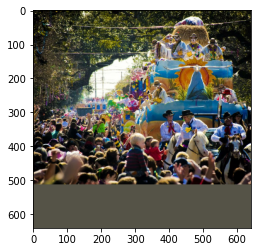

In [21]:
import random
s = random.choice(list(range(10)))
print('Sample number:',s)

for i,j in train_dataset.take(s):
  x = i.numpy()[0,:,:,:]
  y = j.numpy()

plt.imshow(x.astype(np.uint8))
plt.show()

In [22]:
y.shape

(8, 16800, 6)

In [23]:
data = x.copy()

data.max()

255.0

In [24]:
data

array([[[ 3.      ,  0.      ,  0.      ],
        [16.      , 12.      , 13.      ],
        [15.      , 10.      , 14.      ],
        ...,
        [44.      , 45.      , 40.      ],
        [34.      , 34.      , 32.      ],
        [43.      , 43.      , 45.      ]],

       [[ 7.      ,  4.      ,  0.      ],
        [13.      , 10.      ,  3.      ],
        [19.      , 15.      , 12.      ],
        ...,
        [ 8.      ,  9.      ,  4.      ],
        [ 4.      ,  4.      ,  2.      ],
        [ 3.      ,  3.      ,  3.      ]],

       [[ 3.      ,  3.      ,  0.      ],
        [ 3.      ,  2.      ,  0.      ],
        [34.      , 32.      , 17.      ],
        ...,
        [ 1.      ,  2.      ,  0.      ],
        [ 4.      ,  5.      ,  0.      ],
        [ 8.      ,  8.      ,  6.      ]],

       ...,

       [[85.994865, 83.362206, 71.73304 ],
        [85.994865, 83.362206, 71.73304 ],
        [85.994865, 83.362206, 71.73304 ],
        ...,
        [85.994865, 83.362

In [25]:
data = data /270.38324         # normalize the data to 0 - 1
data = 255 * data # Now scale by 255

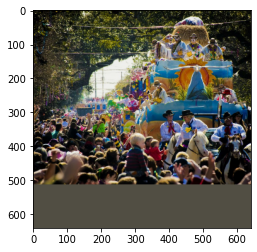

In [26]:
plt.imshow(data.astype(np.uint8))
plt.show()

# losses - only for reference, didn't use

In [ ]:
# def _smooth_l1_loss(y_true, y_pred):
#     t = tf.abs(y_pred - y_true)
#     return tf.where(t < 1, 0.5 * t ** 2, t - 0.5)


# def MultiBoxLoss(num_class=2, neg_pos_ratio=3):
#     """multi-box loss"""
#     def multi_box_loss(y_true, y_pred):
#         num_batch = tf.shape(y_true)[0]
#         num_prior = tf.shape(y_true)[1]

#         loc_pred = tf.reshape(y_pred[0], [num_batch * num_prior, 4])
#         landm_pred = tf.reshape(y_pred[1], [num_batch * num_prior, 10])
#         class_pred = tf.reshape(y_pred[2], [num_batch * num_prior, num_class])

#         loc_true = tf.reshape(y_true[..., :4], [num_batch * num_prior, 4])
#         landm_true = tf.reshape(y_true[..., 4:14], [num_batch * num_prior, 10])
#         landm_valid = tf.reshape(y_true[..., 14], [num_batch * num_prior, 1])
#         class_true = tf.reshape(y_true[..., 15], [num_batch * num_prior, 1])

#         # define filter mask: class_true = 1 (pos), 0 (neg), -1 (ignore)
#         #                     landm_valid = 1 (w landm), 0 (w/o landm)
#         mask_pos = tf.equal(class_true, 1)
#         mask_neg = tf.equal(class_true, 0)
#         mask_landm = tf.logical_and(tf.equal(landm_valid, 1), mask_pos)

#         # landm loss (smooth L1)
#         mask_landm_b = tf.broadcast_to(mask_landm, tf.shape(landm_true))
#         loss_landm = _smooth_l1_loss(tf.boolean_mask(landm_true, mask_landm_b),
#                                      tf.boolean_mask(landm_pred, mask_landm_b))
#         loss_landm = tf.reduce_mean(loss_landm)

#         # localization loss (smooth L1)
#         mask_pos_b = tf.broadcast_to(mask_pos, tf.shape(loc_true))
#         loss_loc = _smooth_l1_loss(tf.boolean_mask(loc_true, mask_pos_b),
#                                    tf.boolean_mask(loc_pred, mask_pos_b))
#         loss_loc = tf.reduce_mean(loss_loc)

#         # classification loss (crossentropy)
#         # 1. compute max conf across batch for hard negative mining
#         loss_class = tf.where(mask_neg,
#                               1 - class_pred[:, 0][..., tf.newaxis], 0)

#         # 2. hard negative mining
#         loss_class = tf.reshape(loss_class, [num_batch, num_prior])
#         loss_class_idx = tf.argsort(loss_class, axis=1, direction='DESCENDING')
#         loss_class_idx_rank = tf.argsort(loss_class_idx, axis=1)
#         mask_pos_per_batch = tf.reshape(mask_pos, [num_batch, num_prior])
#         num_pos_per_batch = tf.reduce_sum(
#                 tf.cast(mask_pos_per_batch, tf.float32), 1, keepdims=True)
#         num_pos_per_batch = tf.maximum(num_pos_per_batch, 1)
#         num_neg_per_batch = tf.minimum(neg_pos_ratio * num_pos_per_batch,
#                                        tf.cast(num_prior, tf.float32) - 1)
#         mask_hard_neg = tf.reshape(
#             tf.cast(loss_class_idx_rank, tf.float32) < num_neg_per_batch,
#             [num_batch * num_prior, 1])

#         # 3. classification loss including positive and negative examples
#         loss_class_mask = tf.logical_or(mask_pos, mask_hard_neg)
#         loss_class_mask_b = tf.broadcast_to(loss_class_mask,
#                                             tf.shape(class_pred))
#         filter_class_true = tf.boolean_mask(tf.cast(mask_pos, tf.float32),
#                                             loss_class_mask)
#         filter_class_pred = tf.boolean_mask(class_pred, loss_class_mask_b)
#         filter_class_pred = tf.reshape(filter_class_pred, [-1, num_class])
#         loss_class = tf.keras.losses.sparse_categorical_crossentropy(
#             y_true=filter_class_true, y_pred=filter_class_pred)
#         loss_class = tf.reduce_mean(loss_class)

#         return loss_loc, loss_landm, loss_class

#     return multi_box_loss

## lr_scheduler

In [ ]:
# def MultiStepLR(initial_learning_rate, lr_steps, lr_rate, name='MultiStepLR'):
#     """Multi-steps learning rate scheduler."""
#     lr_steps_value = [initial_learning_rate]
#     for _ in range(len(lr_steps)):
#         lr_steps_value.append(lr_steps_value[-1] * lr_rate)
#     return tf.keras.optimizers.schedules.PiecewiseConstantDecay(
#         boundaries=lr_steps, values=lr_steps_value)


# def MultiStepWarmUpLR(initial_learning_rate, lr_steps, lr_rate,
#                       warmup_steps=0., min_lr=0.,
#                       name='MultiStepWarmUpLR'):
#     """Multi-steps warm up learning rate scheduler."""
#     assert warmup_steps <= lr_steps[0]
#     assert min_lr <= initial_learning_rate
#     lr_steps_value = [initial_learning_rate]
#     for _ in range(len(lr_steps)):
#         lr_steps_value.append(lr_steps_value[-1] * lr_rate)
#     return PiecewiseConstantWarmUpDecay(
#         boundaries=lr_steps, values=lr_steps_value, warmup_steps=warmup_steps,
#         min_lr=min_lr)


# def CosineAnnealingLR_Restart(initial_learning_rate, t_period, lr_min):
#     """Cosine annealing learning rate scheduler with restart."""
#     return tf.keras.experimental.CosineDecayRestarts(
#         initial_learning_rate=initial_learning_rate,
#         first_decay_steps=t_period, t_mul=1.0, m_mul=1.0,
#         alpha=lr_min / initial_learning_rate)


# class PiecewiseConstantWarmUpDecay(
#         tf.keras.optimizers.schedules.LearningRateSchedule):
#     """A LearningRateSchedule wiht warm up schedule.
#     Modified from tf.keras.optimizers.schedules.PiecewiseConstantDecay"""

#     def __init__(self, boundaries, values, warmup_steps, min_lr,
#                  name=None):
#         super(PiecewiseConstantWarmUpDecay, self).__init__()

#         if len(boundaries) != len(values) - 1:
#             raise ValueError(
#                     "The length of boundaries should be 1 less than the"
#                     "length of values")

#         self.boundaries = boundaries
#         self.values = values
#         self.name = name
#         self.warmup_steps = warmup_steps
#         self.min_lr = min_lr

#     def __call__(self, step):
#         with tf.name_scope(self.name or "PiecewiseConstantWarmUp"):
#             step = tf.cast(tf.convert_to_tensor(step), tf.float32)
#             pred_fn_pairs = []
#             warmup_steps = self.warmup_steps
#             boundaries = self.boundaries
#             values = self.values
#             min_lr = self.min_lr

#             pred_fn_pairs.append(
#                 (step <= warmup_steps,
#                  lambda: min_lr + step * (values[0] - min_lr) / warmup_steps))
#             pred_fn_pairs.append(
#                 (tf.logical_and(step <= boundaries[0],
#                                 step > warmup_steps),
#                  lambda: tf.constant(values[0])))
#             pred_fn_pairs.append(
#                 (step > boundaries[-1], lambda: tf.constant(values[-1])))

#             for low, high, v in zip(boundaries[:-1], boundaries[1:],
#                                     values[1:-1]):
#                 pred = (step > low) & (step <= high)
#                 pred_fn_pairs.append((pred, lambda v=v: tf.constant(v)))

#             # The default isn't needed here because our conditions are mutually
#             # exclusive and exhaustive, but tf.case requires it.
#             return tf.case(pred_fn_pairs, lambda: tf.constant(values[0]),
#                            exclusive=True)

#     def get_config(self):
#         return {
#                 "boundaries": self.boundaries,
#                 "values": self.values,
#                 "warmup_steps": self.warmup_steps,
#                 "min_lr": self.min_lr,
#                 "name": self.name
#         }


# if __name__ == "__main__":
#     lr_scheduler = MultiStepWarmUpLR(1e-2, [5500, 6800], 0.1,
#                                      warmup_steps=500, min_lr=1e-3)
#     # lr_scheduler = MultiStepWarmUpLR(1e-3, [5500, 6800], 0.1)
#     # lr_scheduler = MultiStepLR(1e-4, [500, 1000, 2000, 3000], 0.5)
#     # lr_scheduler = CosineAnnealingLR_Restart(2e-4, 2500, 1e-7)

#     ##############################
#     # Draw figure
#     ##############################
#     N_iter = 10000
#     step_list = list(range(0, N_iter, 10))
#     lr_list = []
#     for i in step_list:
#         current_lr = lr_scheduler(i).numpy()
#         lr_list.append(current_lr)

#     import matplotlib as mpl
#     from matplotlib import pyplot as plt
#     import matplotlib.ticker as mtick
#     mpl.style.use('default')
#     import seaborn
#     seaborn.set(style='whitegrid')
#     seaborn.set_context('paper')

#     plt.figure(1)
#     plt.subplot(111)
#     plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
#     plt.title('Title', fontsize=16, color='k')
#     plt.plot(step_list, lr_list, linewidth=1.5, label='learning rate scheme')
#     legend = plt.legend(loc='upper right', shadow=False)
#     ax = plt.gca()
#     labels = ax.get_xticks().tolist()
#     for k, v in enumerate(labels):
#         labels[k] = str(int(v / 1000)) + 'K'
#     ax.set_xticklabels(labels)
#     ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

#     ax.set_ylabel('Learning rate')
#     ax.set_xlabel('Iteration')
#     fig = plt.gcf()
#     plt.show()

# Modified Model - only bbox and classification

In [27]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.layers import Input, Conv2D, ReLU, LeakyReLU, BatchNormalization

## Model Architecture

In [28]:
cfg

{'backbone_type': 'MobileNetV2',
 'batch_size': 8,
 'clip': False,
 'dataset_len': 12880,
 'dataset_path': '/content/drive/MyDrive/RetinaFace/widerface_train_bin_onlybbox.tfrecord',
 'epoch': 1,
 'ignore_thresh': 0.3,
 'init_lr': 0.01,
 'input_size': 640,
 'lr_decay_epoch': [50, 68],
 'lr_rate': 0.1,
 'match_thresh': 0.45,
 'min_lr': 0.001,
 'min_sizes': [[16, 32], [64, 128], [256, 512]],
 'momentum': 0.9,
 'out_channel': 64,
 'pretrain': True,
 'save_steps': 1000,
 'steps': [8, 16, 32],
 'sub_name': 'retinaface_mbv2',
 'testing_dataset_path': './data/widerface/val',
 'using_bin': True,
 'using_distort': False,
 'using_flip': False,
 'variances': [0.1, 0.2],
 'warmup_epoch': 5,
 'weights_decay': 0.0005}

In [ ]:
# input_size = (640,640,3)

In [ ]:
# base_model = MobileNetV2(input_shape = input_size, include_top=False, weights= 'imagenet')

# base_model.trainable = False

In [ ]:
# base_model.summary()

In [ ]:
# base_model.layers[143].output

<KerasTensor: shape=(None, 20, 20, 960) dtype=float32 (created by layer 'block_16_expand')>

In [ ]:
# base_model.input

<KerasTensor: shape=(None, 640, 640, 3) dtype=float32 (created by layer 'input_2')>

In [ ]:
# pick_layer1 = 54  # [80, 80, 192]
# pick_layer2 = 116  # [40, 40, 576]
# pick_layer3 = 143  # [20, 20, 960]

In [ ]:
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# # define model
# inputs = Input(input_size, name='input_image')

# x = preprocess_input(inputs)
# mobilenetv2_layer1_80 = Model(base_model.input, base_model.layers[pick_layer1].output, name = 'mobilenet_layer54_80')(x)
# mobilenetv2_layer2_40 = Model(base_model.input, base_model.layers[pick_layer2].output, name = 'mobilenet_layer116_40')(x)
# mobilenetv2_layer3_20 = Model(base_model.input, base_model.layers[pick_layer3].output, name = 'mobilenet_layer143_20')(x)

# model = Model(inputs,
#               (mobilenetv2_layer1_80,
#                mobilenetv2_layer2_40,
#                mobilenetv2_layer3_20))

# model.summary()

In [ ]:
1518464 + 613952 + 65152 

2197568

In [29]:
def conv_block(prev_layer, name, filters, kernel, stride, act = True):
    x =  Conv2D(filters = filters, 
                kernel_size = kernel, 
                strides = stride, 
                padding='same',
                kernel_initializer = tf.keras.initializers.he_normal(),
                use_bias = False,
                name = name+'conv')(prev_layer)
    
    x = BatchNormalization(epsilon=1e-5,
                           name = name+'batchnorm')(x)

    if act:
        x = ReLU(name = name+'relu')(x)
               
    
    return x

In [30]:
def fpn(input_layer1, input_layer2, input_layer3):
    output1 = conv_block(input_layer1,
                        'fpn1_',
                        filters = 64,
                        kernel = 1,
                        stride = 1)           #(None, 80, 80, 64)
    
    output2 = conv_block(input_layer2,
                        'fpn2_',
                        filters = 64,
                        kernel = 1,
                        stride = 1)           #(None, 40, 40, 64)
    
    output3 = conv_block(input_layer3,
                        'fpn3_',
                        filters = 64,
                        kernel = 1,
                        stride = 1)           #(None, 20, 20, 64)
    
    #Up sampling + feature fusion
    up_h2, up_w2 = tf.shape(output2)[1], tf.shape(output2)[2]         #up_h = 40, up_w = 40
    up3 = tf.image.resize(output3, [up_h2, up_w2], method='nearest')   # (None,40,40,64)
    output2 = output2 + up3                                                         # (None,40,40,64)


    merge2 = conv_block(output2,
                        'fpn2_merge_',
                        filters = 64,
                        kernel = 3,
                        stride = 1)                                                  # (None,40,40,64)
    

    #Up sampling + feature fusion
    up_h1, up_w1 = tf.shape(output1)[1], tf.shape(output1)[2]         #up_h = 80, up_w = 80
    up2 = tf.image.resize(merge2, [up_h1, up_w1], method='nearest')   # (None,80,80,64)
    output1 = output1 + up2                                                  # (None,80,80,64)


    merge1 = conv_block(output1,
                        'fpn1_merge_',
                        filters = 64,
                        kernel = 3,
                        stride = 1)                                               # (None,80,80,64)

                        
    return merge1, merge2, output3

In [ ]:
# o1,o2,o3 = fpn(mobilenetv2_layer1_80, mobilenetv2_layer2_40, mobilenetv2_layer3_20)

# print(o1)
# print(o2)
# print(o3)

In [31]:
def ssh(prev_layer, name):
    conv_3x3 = conv_block(prev_layer,
                        name = name + 'conv_3x3',
                        filters = 64//2,
                        kernel = 3,
                        stride = 1,
                         act = False)      

    conv_5x5_1 = conv_block(prev_layer,
                        name = name + 'conv_5x5_1',
                        filters = 64//4,
                        kernel = 3,
                        stride = 1,
                         act = True)  
    conv_5x5 = conv_block(conv_5x5_1,
                        name = name + 'conv_5x5',
                        filters = 64//4,
                        kernel = 3,
                        stride = 1,
                         act = False)  

    conv_7x7_1 = conv_block(conv_5x5_1,
                        name = name + 'conv_7x7_1',
                        filters = 64//4,
                        kernel = 3,
                        stride = 1,
                         act = True)  
    conv_7x7 = conv_block(conv_7x7_1,
                        name = name + 'conv_7x7',
                        filters = 64//4,
                        kernel = 3,
                        stride = 1,
                         act = False)    

    output = tf.concat([conv_3x3, conv_5x5, conv_7x7], axis=3)
    output = keras.layers.ReLU(name = name+'final_relu')(output)   

    return output

In [ ]:
# ssh2 = ssh(o2, 'ssh2_40_')

In [ ]:
# ssh2

<KerasTensor: shape=(None, 40, 40, 64) dtype=float32 (created by layer 'ssh2_40_final_relu')>

In [32]:
min_sizes = [[16, 32], [64, 128], [256, 512]]
len(min_sizes)

3

In [33]:
def classification_head(prev_layer, num_anchor, name):

    conv_1x1 = keras.layers.Conv2D(filters = num_anchor * 2, 
                                   kernel_size = 1, 
                                   strides = 1,
                                   name = name)(prev_layer)
    
    h, w = tf.shape(prev_layer)[1], tf.shape(prev_layer)[2]

    return tf.reshape(conv_1x1, [-1, h * w * num_anchor, 2])


def bbox_head(prev_layer, num_anchor, name):

    conv_1x1 = keras.layers.Conv2D(filters = num_anchor * 4, 
                                   kernel_size = 1, 
                                   strides = 1,
                                   name = name)(prev_layer)
    
    h, w = tf.shape(prev_layer)[1], tf.shape(prev_layer)[2]

    return tf.reshape(conv_1x1, [-1, h * w * num_anchor, 4])

In [34]:
cfg['input_size']

640

In [35]:
# define model
def make_model(input_size, is_training = False):
  '''Make model architecture'''

  if is_training:
    input_size = input_size
  else:
    input_size = None

  base_model = MobileNetV2(input_shape = [input_size, input_size, 3], include_top=False, weights= 'imagenet')
  base_model.trainable = False  

  pick_layer1 = 54  # [80, 80, 192]
  pick_layer2 = 116  # [40, 40, 576]
  pick_layer3 = 143  # [20, 20, 960]

  preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

  inputs = Input([input_size, input_size, 3], name='input_image')
  x = preprocess_input(inputs)

  mobilenetv2_layer1_80 = Model(base_model.input, base_model.layers[pick_layer1].output, name = 'mobilenet_layer54_80')(x)      #(None, 80, 80, 192)
  mobilenetv2_layer2_40 = Model(base_model.input, base_model.layers[pick_layer2].output, name = 'mobilenet_layer116_40')(x)      #(None, 40, 40, 576)
  mobilenetv2_layer3_20 = Model(base_model.input, base_model.layers[pick_layer3].output, name = 'mobilenet_layer143_20')(x)      #(None, 20, 20, 960)

  #feature pyramid network
  fpn_layer1_80, fpn_layer2_40, fpn_layer3_20 = fpn(mobilenetv2_layer1_80, mobilenetv2_layer2_40, mobilenetv2_layer3_20)

  ssh_layer1 = ssh(fpn_layer1_80, name = 'ssh1_80_')
  ssh_layer2 = ssh(fpn_layer2_40, name = 'ssh2_40_')
  ssh_layer3 = ssh(fpn_layer3_20, name = 'ssh3_20_')

  #Classification head
  classification_layer1 = classification_head(ssh_layer1, len(min_sizes[0]), 'classification_layer1')
  classification_layer2 = classification_head(ssh_layer2, len(min_sizes[0]), 'classification_layer2')
  classification_layer3 = classification_head(ssh_layer3, len(min_sizes[0]), 'classification_layer3')

  classifications = tf.concat([classification_layer1,
                              classification_layer2,
                              classification_layer3], axis=1)

  #classification activation function 
  classifications = tf.keras.layers.Softmax(axis = -1, name = 'classifications_softmax')(classifications)


  #bounding box regressions head
  bbox_layer1 = bbox_head(ssh_layer1, len(min_sizes[0]), 'bbox_layer1')
  bbox_layer2 = bbox_head(ssh_layer2, len(min_sizes[0]), 'bbox_layer2')
  bbox_layer3 = bbox_head(ssh_layer3, len(min_sizes[0]), 'bbox_layer3')

  bbox_regressions = tf.concat([bbox_layer1,
                                bbox_layer2,
                                bbox_layer3], axis=1)

  #output
  output = (bbox_regressions, classifications)

  model = Model(inputs, output)

  return model


In [52]:
cfg['input_size']

640

In [63]:
model_train = make_model(640, is_training = True)
model_train.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_1 (TFOpLambda)  (None, 640, 640, 3)  0          ['input_image[0][0]']            
                                                                                                  
 tf.math.subtract_1 (TFOpLambda  (None, 640, 640, 3)  0          ['tf.math.truediv_1[0][0]']      
 )                                                                                                
                                                                                            

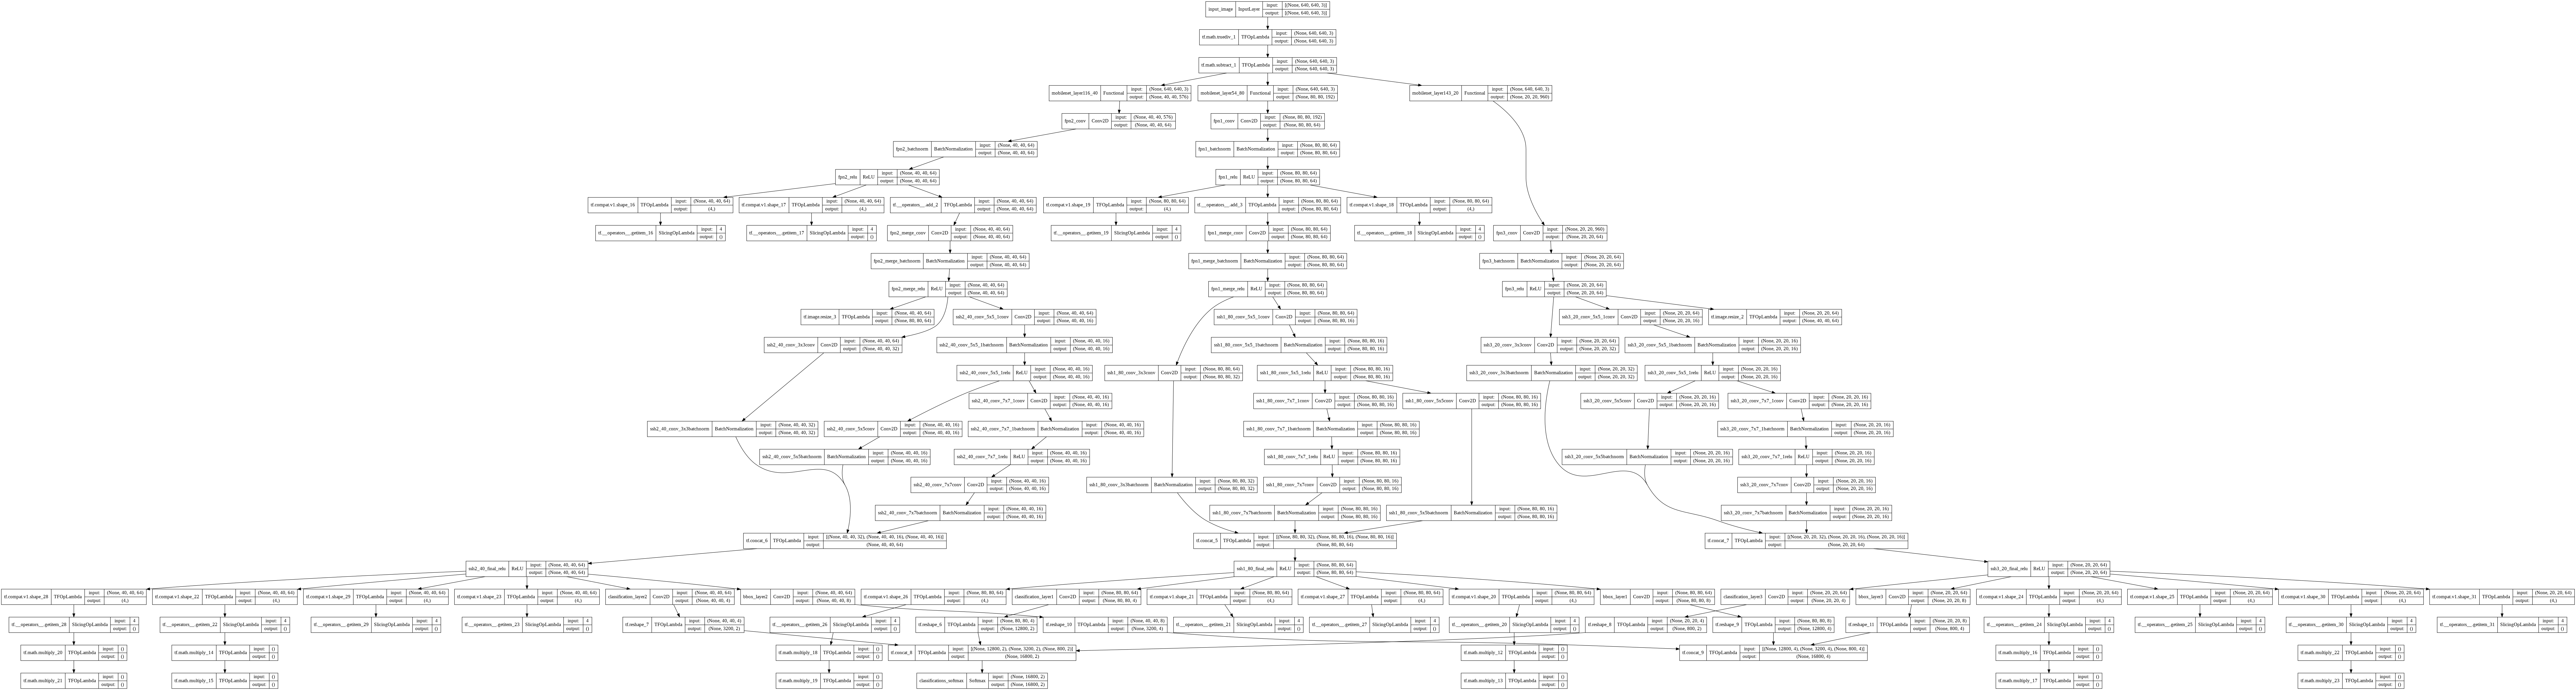

In [64]:
tf.keras.utils.plot_model(model_train, 
                          to_file='/content/drive/MyDrive/RetinaFace/Modified/model_modified_for _training.png', 
                          show_shapes=True,
                          show_layer_names=True)

In [65]:
model_json = model_train.to_json()
with open("/content/drive/MyDrive/RetinaFace/Modified/model_modified_for_training.json", "w") as json_file:
    json_file.write(model_json)


#model.save_weights('/content/drive/MyDrive/RetinaFace/Modified/model_modified_withoutTraining.h5')


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
#model.save("./saved_model/")

In [66]:
model_test = make_model(640, is_training = False)
model_test.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 tf.math.truediv_2 (TFOpLambda)  (None, None, None,   0          ['input_image[0][0]']            
                                3)                                                                
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, None, None,   0          ['tf.math.truediv_2[0][0]']      
 )                              3)                                                          

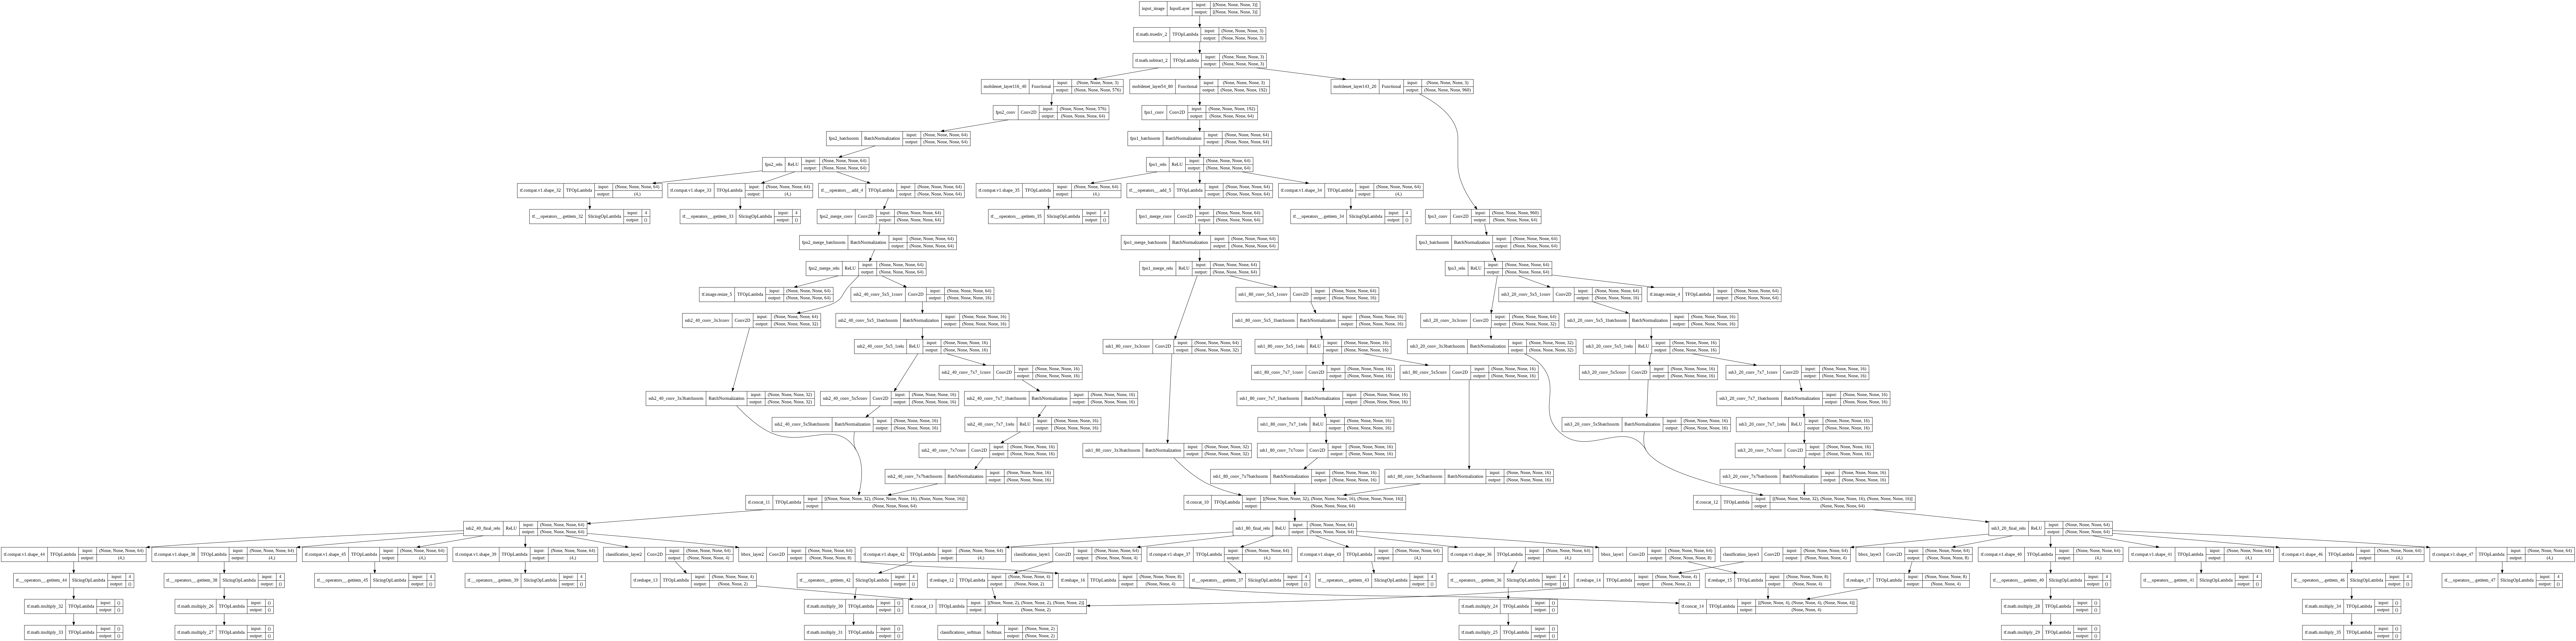

In [67]:
tf.keras.utils.plot_model(model_test, 
                          to_file='/content/drive/MyDrive/RetinaFace/Modified/model_modified_for _testing.png', 
                          show_shapes=True,
                          show_layer_names=True)

In [68]:
model_json = model_test.to_json()
with open("/content/drive/MyDrive/RetinaFace/Modified/model_modified_for_testing.json", "w") as json_file:
    json_file.write(model_json)


#model.save_weights('/content/drive/MyDrive/RetinaFace/Modified/model_modified_withoutTraining.h5')


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Model Training

## Defining loss function

In [36]:
def _smooth_l1_loss(y_true, y_pred):
    t = tf.abs(y_pred - y_true)
    return tf.where(t < 1, 0.5 * t ** 2, t - 0.5)


In [37]:
def MultiBoxLoss(num_class=2, neg_pos_ratio=3):
    """multi-box loss

    y_pred: is tuple of 3 elements
    (TensorShape([1, 16800, 4]),   #bbox
     TensorShape([1, 16800, 10]),   #landm
     TensorShape([1, 16800, 2]))    #classification
    """
    def multi_box_loss(y_true, y_pred):
        num_batch = tf.shape(y_true)[0]
        num_prior = tf.shape(y_true)[1]

        #predictions
        loc_pred = tf.reshape(y_pred[0], [num_batch * num_prior, 4])
        #landm_pred = tf.reshape(y_pred[1], [num_batch * num_prior, 10])
        class_pred = tf.reshape(y_pred[1], [num_batch * num_prior, num_class])

        #ground truths
        loc_true = tf.reshape(y_true[..., :4], [num_batch * num_prior, 4])
        #landm_true = tf.reshape(y_true[..., 4:14], [num_batch * num_prior, 10])
        landm_valid = tf.reshape(y_true[..., 4], [num_batch * num_prior, 1])
        class_true = tf.reshape(y_true[..., 5], [num_batch * num_prior, 1])

        # define filter mask: class_true = 1 (pos), 0 (neg), -1 (ignore)
        #                     landm_valid = 1 (w landm), 0 (w/o landm)
        mask_pos = tf.equal(class_true, 1)
        mask_neg = tf.equal(class_true, 0)
        mask_landm = tf.logical_and(tf.equal(landm_valid, 1), mask_pos)

        '''# landm loss (smooth L1)
        mask_landm_b = tf.broadcast_to(mask_landm, tf.shape(landm_true))
        loss_landm = _smooth_l1_loss(tf.boolean_mask(landm_true, mask_landm_b),
                                     tf.boolean_mask(landm_pred, mask_landm_b))
        loss_landm = tf.reduce_mean(loss_landm)'''

        # localization loss (smooth L1)
        mask_pos_b = tf.broadcast_to(mask_pos, tf.shape(loc_true))
        loss_loc = _smooth_l1_loss(tf.boolean_mask(loc_true, mask_pos_b),
                                   tf.boolean_mask(loc_pred, mask_pos_b))
        loss_loc = tf.reduce_mean(loss_loc)

        # classification loss (crossentropy)
        # 1. compute max conf across batch for hard negative mining
        loss_class = tf.where(mask_neg,
                              1 - class_pred[:, 0][..., tf.newaxis], 0)

        # 2. hard negative mining
        loss_class = tf.reshape(loss_class, [num_batch, num_prior])
        loss_class_idx = tf.argsort(loss_class, axis=1, direction='DESCENDING')
        loss_class_idx_rank = tf.argsort(loss_class_idx, axis=1)
        mask_pos_per_batch = tf.reshape(mask_pos, [num_batch, num_prior])
        num_pos_per_batch = tf.reduce_sum(
                tf.cast(mask_pos_per_batch, tf.float32), 1, keepdims=True)
        num_pos_per_batch = tf.maximum(num_pos_per_batch, 1)
        num_neg_per_batch = tf.minimum(neg_pos_ratio * num_pos_per_batch,
                                       tf.cast(num_prior, tf.float32) - 1)
        mask_hard_neg = tf.reshape(
            tf.cast(loss_class_idx_rank, tf.float32) < num_neg_per_batch,
            [num_batch * num_prior, 1])

        # 3. classification loss including positive and negative examples
        loss_class_mask = tf.logical_or(mask_pos, mask_hard_neg)
        loss_class_mask_b = tf.broadcast_to(loss_class_mask,
                                            tf.shape(class_pred))
        filter_class_true = tf.boolean_mask(tf.cast(mask_pos, tf.float32),
                                            loss_class_mask)
        filter_class_pred = tf.boolean_mask(class_pred, loss_class_mask_b)
        filter_class_pred = tf.reshape(filter_class_pred, [-1, num_class])
        loss_class = tf.keras.losses.sparse_categorical_crossentropy(
            y_true=filter_class_true, y_pred=filter_class_pred)
        loss_class = tf.reduce_mean(loss_class)

        return loss_loc, loss_class

    return multi_box_loss

## Training

In [38]:
for i,j in train_dataset.take(10):
  xtemp = i
  ytemp = j
  
  print(xtemp.shape)
  print(ytemp.shape)

(8, 640, 640, 3)
(8, 16800, 6)
(8, 640, 640, 3)
(8, 16800, 6)
(8, 640, 640, 3)
(8, 16800, 6)
(8, 640, 640, 3)
(8, 16800, 6)
(8, 640, 640, 3)
(8, 16800, 6)
(8, 640, 640, 3)
(8, 16800, 6)
(8, 640, 640, 3)
(8, 16800, 6)
(8, 640, 640, 3)
(8, 16800, 6)
(8, 640, 640, 3)
(8, 16800, 6)
(8, 640, 640, 3)
(8, 16800, 6)


In [39]:
for i,j in train_dataset.take(1):
  xtemp = i
  ytemp = j
  
print(xtemp.shape)
print(ytemp.shape)

(8, 640, 640, 3)
(8, 16800, 6)


In [40]:
cfg

{'backbone_type': 'MobileNetV2',
 'batch_size': 8,
 'clip': False,
 'dataset_len': 12880,
 'dataset_path': '/content/drive/MyDrive/RetinaFace/widerface_train_bin_onlybbox.tfrecord',
 'epoch': 1,
 'ignore_thresh': 0.3,
 'init_lr': 0.01,
 'input_size': 640,
 'lr_decay_epoch': [50, 68],
 'lr_rate': 0.1,
 'match_thresh': 0.45,
 'min_lr': 0.001,
 'min_sizes': [[16, 32], [64, 128], [256, 512]],
 'momentum': 0.9,
 'out_channel': 64,
 'pretrain': True,
 'save_steps': 1000,
 'steps': [8, 16, 32],
 'sub_name': 'retinaface_mbv2',
 'testing_dataset_path': './data/widerface/val',
 'using_bin': True,
 'using_distort': False,
 'using_flip': False,
 'variances': [0.1, 0.2],
 'warmup_epoch': 5,
 'weights_decay': 0.0005}

In [41]:
model = make_model(640, is_training = True)
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 640, 640, 3)  0           ['input_image[0][0]']            
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 640, 640, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 mobilenet_layer116_40 (Functio

In [52]:
# define losses function
multi_box_loss = MultiBoxLoss()

# define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

# define training step function
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs)

        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)
        losses['loc'], losses['class'] =  multi_box_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses

In [79]:
# tl, l = train_step(xtemp, ytemp)

# print(tl)
# print(l)

tf.Tensor(16.426168, shape=(), dtype=float32)
{'reg': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'loc': <tf.Tensor: shape=(), dtype=float32, numpy=3.7956564>, 'class': <tf.Tensor: shape=(), dtype=float32, numpy=12.630511>}


In [80]:
# tl.numpy()

16.426168

In [81]:
# l['reg'].numpy(), l['loc'].numpy(), l['class'].numpy()

(0.0, 3.7956564, 12.630511)

In [44]:
steps_per_epoch =  cfg['dataset_len'] // cfg['batch_size']
steps_per_epoch

1610

In [45]:
from datetime import datetime


In [54]:
idx = 0
epoch_number = 3
start = datetime.now()
for inputs,labels in train_dataset.take(steps_per_epoch):

  total_loss, losses = train_step(inputs, labels)

  print('Step number:',idx)
  print(f'     Model losses: {model.losses}')
  print(f'     Total loss: {total_loss.numpy()}')
  print(f'     reg loss: {losses["reg"].numpy()} loc/bbox loss: {losses["loc"].numpy()} class loss: {losses["class"].numpy()}')
 
  if idx in [400,800,1200,1600]:
    model.save_weights(f'/content/drive/MyDrive/RetinaFace/Modified/model_modified_Training_epoch{epoch_number}_iteration{idx}.h5')  
  
  idx+=1


model.save_weights(f'/content/drive/MyDrive/RetinaFace/Modified/model_modified_Training_epoch{epoch_number}.h5')  

print('Done')
end = datetime.now()
print(f'Time take to train 1st epoch is:', end - start)



Streaming output truncated to the last 5000 lines.
     Total loss: 0.44518154859542847
     reg loss: 0.0 loc/bbox loss: 0.2769920229911804 class loss: 0.16818954050540924
Step number: 361
     Model losses: []
     Total loss: 0.3225277066230774
     reg loss: 0.0 loc/bbox loss: 0.1705102026462555 class loss: 0.1520175188779831
Step number: 362
     Model losses: []
     Total loss: 0.6681724786758423
     reg loss: 0.0 loc/bbox loss: 0.3858005404472351 class loss: 0.2823719382286072
Step number: 363
     Model losses: []
     Total loss: 0.26860201358795166
     reg loss: 0.0 loc/bbox loss: 0.17482872307300568 class loss: 0.09377329051494598
Step number: 364
     Model losses: []
     Total loss: 0.38887831568717957
     reg loss: 0.0 loc/bbox loss: 0.2542450428009033 class loss: 0.13463327288627625
Step number: 365
     Model losses: []
     Total loss: 0.3650997579097748
     reg loss: 0.0 loc/bbox loss: 0.20766352117061615 class loss: 0.15743623673915863
Step number: 366
     Mod

In [48]:
model.losses

[]

In [ ]:
# model.save_weights('/content/drive/MyDrive/RetinaFace/Modified/model_modified_Training_iterations518.h5')  

# Post processing model output - functions

## Dencoding

In [66]:
###############################################################################
#   Tensorflow Decoding                                                       #
###############################################################################
def decode_tf(labels, priors, variances=[0.1, 0.2]):
    """tensorflow decoding"""
    bbox = _decode_bbox(labels[:, :4], priors, variances)
    
    #dummy data for landm
    #landm = tf.concat([labels[:, :4],labels[:, :4]], axis=1) 
    #landm = _decode_landm(landm, priors, variances)
    #

    landm_valid = labels[:, 4][:, tf.newaxis]
    conf = labels[:, 5][:, tf.newaxis]

    return tf.concat(
        [bbox, 
         #landm, 
         landm_valid, 
         conf], 
         axis=1)


def _decode_bbox(pre, priors, variances=[0.1, 0.2]):
    """Decode locations from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        pre (tensor): location predictions for loc layers,
            Shape: [num_priors,4]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded bounding box predictions
    """
    centers = priors[:, :2] + pre[:, :2] * variances[0] * priors[:, 2:]
    sides = priors[:, 2:] * tf.math.exp(pre[:, 2:] * variances[1])

    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)


def _decode_landm(pre, priors, variances=[0.1, 0.2]):
    """Decode landm from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        pre (tensor): landm predictions for loc layers,
            Shape: [num_priors,10]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded landm predictions
    """
    landms = tf.concat(
        [priors[:, :2] + pre[:, :2] * variances[0] * priors[:, 2:],
         priors[:, :2] + pre[:, 2:4] * variances[0] * priors[:, 2:],
         priors[:, :2] + pre[:, 4:6] * variances[0] * priors[:, 2:],
         priors[:, :2] + pre[:, 6:8] * variances[0] * priors[:, 2:],
         priors[:, :2] + pre[:, 8:10] * variances[0] * priors[:, 2:]], axis=1)
    return landms

# understanding output - Postprocessing model output

In [93]:
for i,j in train_dataset.take(5):
  xtemp = i.numpy()[0,:,:,:]
  ytemp = j.numpy()[0]


In [94]:
xtemp.shape, ytemp.shape

((640, 640, 3), (16800, 6))

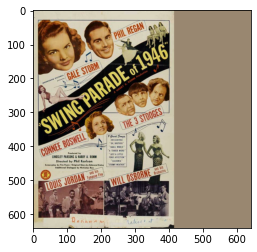

In [95]:
plt.imshow(xtemp.astype(np.uint8))
plt.show()

In [96]:
xtemp = np.expand_dims(xtemp, axis=0)
ytemp = np.expand_dims(ytemp, axis=0)

xtemp.shape, ytemp.shape

((1, 640, 640, 3), (1, 16800, 6))

In [97]:
model_output = model(xtemp)
model_output

(<tf.Tensor: shape=(1, 16800, 4), dtype=float32, numpy=
 array([[[  1.353014  ,  -0.03014908,  -1.1635627 ,  -0.34299916],
         [  0.95300364,  -1.7458034 ,  -2.1014833 ,  -1.3635979 ],
         [ -0.2638216 ,  -0.48132747,  -0.04459612,  -1.66779   ],
         ...,
         [  4.3287196 ,   5.052203  , -12.43219   ,  -0.49918482],
         [  9.387395  ,  -1.7493322 ,  -1.3451667 ,   5.898905  ],
         [  8.154071  ,   2.2668602 , -13.26428   ,   3.5144813 ]]],
       dtype=float32)>, <tf.Tensor: shape=(1, 16800, 2), dtype=float32, numpy=
 array([[[9.9544263e-01, 4.5573376e-03],
         [9.9854255e-01, 1.4574662e-03],
         [9.9839848e-01, 1.6015224e-03],
         ...,
         [1.0000000e+00, 1.1956405e-12],
         [1.0000000e+00, 2.9529544e-14],
         [1.0000000e+00, 9.7451207e-17]]], dtype=float32)>)

In [ ]:
# preds = ytemp.copy()
# preds = preds[0]
# preds.shape

(16800, 6)

In [98]:
#preds
preds = tf.concat(
    [model_output[0][0],
    tf.ones_like(model_output[1][0, :, 0][..., tf.newaxis]),
    model_output[1][0, :, 1][..., tf.newaxis]],
    axis = 1
)

preds.shape

TensorShape([16800, 6])

In [ ]:
# tf.shape(inputs)[1] = 640

In [ ]:
cfg

{'backbone_type': 'MobileNetV2',
 'batch_size': 1,
 'clip': False,
 'dataset_len': 12880,
 'dataset_path': '/content/drive/MyDrive/RetinaFace/widerface_train_bin_onlybbox.tfrecord',
 'epoch': 1,
 'ignore_thresh': 0.3,
 'init_lr': 0.01,
 'input_size': 640,
 'lr_decay_epoch': [50, 68],
 'lr_rate': 0.1,
 'match_thresh': 0.45,
 'min_lr': 0.001,
 'min_sizes': [[16, 32], [64, 128], [256, 512]],
 'momentum': 0.9,
 'out_channel': 64,
 'pretrain': True,
 'save_steps': 1000,
 'steps': [8, 16, 32],
 'sub_name': 'retinaface_mbv2',
 'testing_dataset_path': './data/widerface/val',
 'using_bin': True,
 'using_distort': False,
 'using_flip': False,
 'variances': [0.1, 0.2],
 'warmup_epoch': 5,
 'weights_decay': 0.0005}

In [99]:
priors = prior_box_tf((640, 640),
                      cfg['min_sizes'],  cfg['steps'], cfg['clip'])

type(priors)

tensorflow.python.framework.ops.EagerTensor

In [100]:
priors

<tf.Tensor: shape=(16800, 4), dtype=float32, numpy=
array([[0.00625, 0.00625, 0.025  , 0.025  ],
       [0.00625, 0.00625, 0.05   , 0.05   ],
       [0.01875, 0.00625, 0.025  , 0.025  ],
       ...,
       [0.925  , 0.975  , 0.8    , 0.8    ],
       [0.975  , 0.975  , 0.4    , 0.4    ],
       [0.975  , 0.975  , 0.8    , 0.8    ]], dtype=float32)>

In [101]:
decode_preds = decode_tf(preds, priors, cfg['variances'])

type(decode_preds)

tensorflow.python.framework.ops.EagerTensor

In [102]:
decode_preds

<tf.Tensor: shape=(16800, 6), dtype=float32, numpy=
array([[-2.7223118e-04, -5.4966263e-03,  1.9537302e-02,  1.7845880e-02,
         1.0000000e+00,  4.5573376e-03],
       [-5.4062810e-03, -2.1511672e-02,  2.7436318e-02,  1.6553639e-02,
         1.0000000e+00,  1.4574662e-03],
       [ 5.7014422e-03, -3.9079478e-03,  3.0479454e-02,  1.4001311e-02,
         1.0000000e+00,  1.6015224e-03],
       ...,
       [ 1.2380153e+00,  1.0171824e+00,  1.3045799e+00,  1.7411704e+00,
         1.0000000e+00,  1.1956405e-12],
       [ 1.1976722e+00,  2.5429446e-01,  1.5033194e+00,  1.5557590e+00,
         1.0000000e+00,  2.9529544e-14],
       [ 1.5991459e+00,  3.4851140e-01,  1.6555057e+00,  1.9641862e+00,
         1.0000000e+00,  9.7451207e-17]], dtype=float32)>

In [103]:
tf.shape(decode_preds)[0]

<tf.Tensor: shape=(), dtype=int32, numpy=16800>

In [114]:
iou_th = .2
# score_th = .02
score_th = .9
vis_th = .5

In [115]:
selected_indices = tf.image.non_max_suppression(
        boxes = decode_preds[:, :4],
        scores = decode_preds[:, -1],
        max_output_size = tf.shape(decode_preds)[0],
        iou_threshold = iou_th,
        score_threshold = score_th)

In [116]:
selected_indices

<tf.Tensor: shape=(7,), dtype=int32, numpy=array([13224, 14192, 14504, 14046, 13371, 10748,  5199], dtype=int32)>

In [117]:
out = tf.gather(decode_preds, selected_indices)
out

<tf.Tensor: shape=(7, 6), dtype=float32, numpy=
array([[0.26087388, 0.08306164, 0.3631085 , 0.21889707, 1.        ,
        0.9998727 ],
       [0.38514373, 0.38969448, 0.46365646, 0.48738995, 1.        ,
        0.99801636],
       [0.27130383, 0.4854477 , 0.33994985, 0.5732729 , 1.        ,
        0.99760866],
       [0.5460551 , 0.34368443, 0.6113677 , 0.4324202 , 1.        ,
        0.99706775],
       [0.05399854, 0.09963081, 0.20421702, 0.2802951 , 1.        ,
        0.9965855 ],
       [0.16789104, 0.83492154, 0.1898085 , 0.8617937 , 1.        ,
        0.97946197],
       [0.46311116, 0.36035195, 0.52455074, 0.4355739 , 1.        ,
        0.9770783 ]], dtype=float32)>

In [118]:
out = out.numpy()
out.shape

(7, 6)

In [119]:
for o in out:
  print(o.shape)
  print(o)
  print('*'*50)

(6,)
[0.26087388 0.08306164 0.3631085  0.21889707 1.         0.9998727 ]
**************************************************
(6,)
[0.38514373 0.38969448 0.46365646 0.48738995 1.         0.99801636]
**************************************************
(6,)
[0.27130383 0.4854477  0.33994985 0.5732729  1.         0.99760866]
**************************************************
(6,)
[0.5460551  0.34368443 0.6113677  0.4324202  1.         0.99706775]
**************************************************
(6,)
[0.05399854 0.09963081 0.20421702 0.2802951  1.         0.9965855 ]
**************************************************
(6,)
[0.16789104 0.83492154 0.1898085  0.8617937  1.         0.97946197]
**************************************************
(6,)
[0.46311116 0.36035195 0.52455074 0.4355739  1.         0.9770783 ]
**************************************************


In [ ]:
# def recover_pad_output(outputs, pad_params):
#     """recover the padded output effect"""
#     img_h, img_w, img_pad_h, img_pad_w = pad_params
#     recover_xy = np.reshape(outputs[:, :14], [-1, 7, 2]) * \
#         [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
#     outputs[:, :14] = np.reshape(recover_xy, [-1, 14])

#     return outputs

In [ ]:
# outputs = recover_pad_output(out, (640,640,0,0))

In [ ]:
# outputs.shape

(5997, 16)

In [120]:
im = xtemp[0].copy()
im.shape

(640, 640, 3)

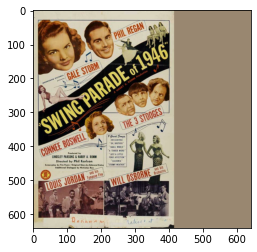

In [121]:
plt.imshow(im.astype(np.uint8))
plt.show()

In [110]:
###############################################################################
#   Visulization                                                              #
###############################################################################
def draw_bbox(img, ann, img_height, img_width):
    """draw bboxes and landmarks"""
    # bbox
    x1, y1, x2, y2 = int(ann[0] * img_width), int(ann[1] * img_height), \
                     int(ann[2] * img_width), int(ann[3] * img_height)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # confidence
    text = "{:.4f}".format(ann[5])
    cv2.putText(img, text, (int(ann[0] * img_width), int(ann[1] * img_height)),
                cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))



def draw_anchor(img, prior, img_height, img_width):
    """draw anchors"""
    x1 = int(prior[0] * img_width - prior[2] * img_width / 2)
    y1 = int(prior[1] * img_height - prior[3] * img_height / 2)
    x2 = int(prior[0] * img_width + prior[2] * img_width / 2)
    y2 = int(prior[1] * img_height + prior[3] * img_height / 2)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 0), 1)

In [122]:
for o in out:
  draw_bbox(im, o, 640, 640)

In [ ]:
# for s in out:
#     x,y,w,h = s[:4]
#     cv2.rectangle(im, (int(x), int(y)),(int(x+w), int(y+h)), (0,255,0), 4)

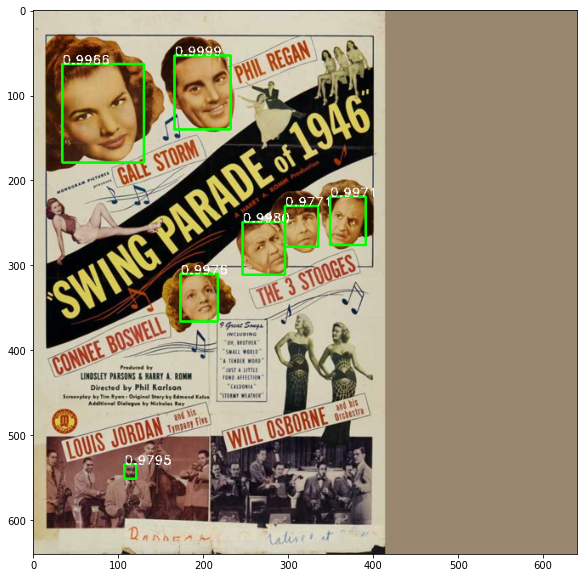

In [123]:
plt.figure(figsize=(10,10))
plt.imshow(im.astype(np.uint8))
plt.show()

# Reading and testing model

In [ ]:
sample_input = np.load('/content/drive/MyDrive/RetinaFace/Dataset_numpy/data/1.npy', allow_pickle = True)
sample_output = np.load('/content/drive/MyDrive/RetinaFace/Dataset_numpy/labels/1.npy', allow_pickle = True)

print(sample_input.shape)
print(sample_output.shape)

(640, 640, 3)
(16800, 6)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


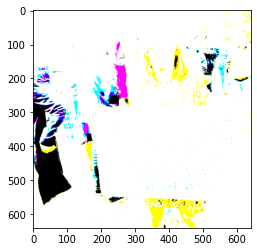

In [ ]:
plt.imshow(sample_input)
plt.show()

In [ ]:
sample_input = np.expand_dims(sample_input,0)
sample_output = np.expand_dims(sample_output,0)

print(sample_input.shape)
print(sample_output.shape)

(1, 640, 640, 3)
(1, 16800, 6)


In [ ]:
# load json and create model
with open("/content/drive/MyDrive/RetinaFace/Modified/model_modified.json", 'r') as json_file:
    model_json = json_file.read()

# load weights into new model
loaded_model = tf.keras.models.model_from_json(model_json)
loaded_model.load_weights("/content/drive/MyDrive/RetinaFace/Modified/model_modified_Training_iterations518.h5")

In [ ]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_2 (TFOpLambda)  (None, 640, 640, 3)  0          ['input_image[0][0]']            
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 640, 640, 3)  0          ['tf.math.truediv_2[0][0]']      
 )                                                                                                
                                                                                              

In [ ]:
sample_input_8, sample_output_8 = train_gen.__getitem__(1600)

print(sample_input_8.shape)
print(sample_output_8.shape)

(8, 640, 640, 3)
(8, 16800, 6)


In [ ]:
%timeit -n5 2+3

5 loops, best of 5: 65.2 ns per loop


In [ ]:
%timeit -n5 loaded_model(sample_input)

5 loops, best of 5: 203 ms per loop


In [ ]:
# #for 1 sample
# sample_pred = loaded_model(sample_input)
# sample_pred

In [ ]:
#for 1 sample
sample_pred = loaded_model(sample_input_8)
sample_pred

In [ ]:
type(sample_pred)

list

In [ ]:
multi_box_loss = MultiBoxLoss()
a,b =  multi_box_loss(sample_output_8, sample_pred)

print(a)
print(b)

tf.Tensor(0.66464496, shape=(), dtype=float32)
tf.Tensor(0.6271524, shape=(), dtype=float32)


In [ ]:
loaded_model.save("/content/drive/MyDrive/RetinaFace/Modified/saved_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/RetinaFace/Modified/saved_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


# Quantization

## tflite - **Without quantization**

In [ ]:
# converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/RetinaFace/Modified/saved_model")
# tflite_model = converter.convert()

In [ ]:
# open("/content/drive/MyDrive/RetinaFace/Modified/model_without_quant.tflite", "wb").write(tflite_model)

7388124

In [ ]:
type(tflite_model)

bytes

In [ ]:
len(tflite_model)

7388124

In [ ]:
len(tflite_model)/1000_000

7.388124

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/RetinaFace/Modified/model_without_quant.tflite")
interpreter.allocate_tensors()

In [ ]:
dir(interpreter)

In [ ]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'serving_default_input_image:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 640, 640,   3], dtype=int32),
  'shape_signature': array([ -1, 640, 640,   3], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
output_details

[{'dtype': numpy.float32,
  'index': 274,
  'name': 'StatefulPartitionedCall:1',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([    1, 16800,     4], dtype=int32),
  'shape_signature': array([   -1, 16800,     4], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.float32,
  'index': 277,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([    1, 16800,     2], dtype=int32),
  'shape_signature': array([   -1, 16800,     2], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
sample_input.shape, sample_output.shape

(1, 640, 640, 3)

In [ ]:
# Test model on input data.
interpreter.set_tensor(input_details[0]['index'], sample_input)

interpreter.invoke()

In [ ]:
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data1 = interpreter.get_tensor(output_details[0]['index'])
output_data2 = interpreter.get_tensor(output_details[1]['index'])

In [ ]:
print(output_data1)

[[[-0.4127545  -1.5728643  -4.55903    -0.40923747]
  [ 1.0854273   2.4942153  -0.08976269  0.52290875]
  [-1.7849374  -2.0133815  -4.6762466  -0.5943247 ]
  ...
  [-0.91692156 -0.02157185 -3.8568854   1.1739311 ]
  [-1.598427    1.6633886  -3.3484266  -1.3257116 ]
  [ 1.5555371  -0.44120577 -0.30481085 -2.481168  ]]]


In [ ]:
output_data1.shape

(1, 16800, 4)

In [ ]:
print(output_data2)

[[[9.9712592e-01 2.8740240e-03]
  [9.8324353e-01 1.6756468e-02]
  [9.9881989e-01 1.1800369e-03]
  ...
  [9.9446493e-01 5.5350387e-03]
  [9.9984455e-01 1.5542649e-04]
  [9.9450994e-01 5.4900032e-03]]]


In [ ]:
output_data2.shape

(1, 16800, 2)

In [ ]:
out_pred = [output_data1, output_data2]

In [ ]:
multi_box_loss = MultiBoxLoss()
a,b =  multi_box_loss(sample_output, out_pred)

print(a)
print(b)

tf.Tensor(0.7543104, shape=(), dtype=float32)
tf.Tensor(0.63122994, shape=(), dtype=float32)


In [ ]:
sample_input_8.shape, sample_output_8.shape

((8, 640, 640, 3), (8, 16800, 6))

In [ ]:
# Test model on input data.
a,b = [],[]
for i,o in zip(sample_input_8, sample_output_8):
  
  i = np.expand_dims(i,0)
  o = np.expand_dims(o,0)
  # print(i.shape, o.shape)

  interpreter.set_tensor(input_details[0]['index'], i)

  interpreter.invoke()

  output_data1 = interpreter.get_tensor(output_details[0]['index'])
  output_data2 = interpreter.get_tensor(output_details[1]['index'])

  out_pred = [output_data1,output_data2]
  multi_box_loss = MultiBoxLoss()
  a1,b1 =  multi_box_loss(o, out_pred)

  a.append(a1.numpy())
  b.append(b1.numpy())

print(a)
print(b)

[0.53056425, 0.554074, 0.6654744, 0.7382624, 0.68064374, 0.63030267, 0.77537036, 0.657935]
[0.5774213, 0.69606584, 0.5569685, 0.9320228, 0.7084929, 0.9715259, 0.53438646, 0.58873725]


In [ ]:
np.mean(a), np.mean(b)

(0.65407836, 0.6957026)

## tflite - **With quantization**

In [ ]:
# converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/RetinaFace/Modified/saved_model")
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_quant_model = converter.convert()

In [ ]:
# open("/content/drive/MyDrive/RetinaFace/Modified/model_with_quant.tflite", "wb").write(tflite_quant_model)

2273376

In [ ]:
type(tflite_quant_model)

bytes

In [ ]:
len(tflite_quant_model)

2273376

In [ ]:
len(tflite_quant_model)/1000_000

2.273376

In [ ]:
# Load TFLite model and allocate tensors.
quant_interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/RetinaFace/Modified/model_with_quant.tflite")
quant_interpreter.allocate_tensors()

In [ ]:
# Get input and output tensors.
input_details = quant_interpreter.get_input_details()
output_details = quant_interpreter.get_output_details()

In [ ]:
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'serving_default_input_image:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 640, 640,   3], dtype=int32),
  'shape_signature': array([ -1, 640, 640,   3], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
output_details

[{'dtype': numpy.float32,
  'index': 274,
  'name': 'StatefulPartitionedCall:1',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([    1, 16800,     4], dtype=int32),
  'shape_signature': array([   -1, 16800,     4], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.float32,
  'index': 277,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([    1, 16800,     2], dtype=int32),
  'shape_signature': array([   -1, 16800,     2], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
sample_input.shape, sample_output.shape

((1, 640, 640, 3), (1, 16800, 6))

In [ ]:
# Test model on input data.
quant_interpreter.set_tensor(input_details[0]['index'], sample_input)

quant_interpreter.invoke()

In [ ]:
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data1 = quant_interpreter.get_tensor(output_details[0]['index'])
output_data2 = quant_interpreter.get_tensor(output_details[1]['index'])

In [ ]:
output_data1

array([[[-0.2147151 , -1.5301219 , -4.695122  , -0.33596018],
        [ 1.1926262 ,  2.5578892 , -0.16545063,  0.44747844],
        [-1.6476488 , -2.0478158 , -4.8182316 , -0.5191489 ],
        ...,
        [-0.86458427,  0.04930546, -3.3551204 ,  1.0508697 ],
        [-1.6168034 ,  1.6842387 , -3.1889796 , -1.5622228 ],
        [ 1.2766899 , -0.42298612, -0.43460312, -2.3010695 ]]],
      dtype=float32)

In [ ]:
output_data1.shape

(1, 16800, 4)

In [ ]:
output_data2

array([[[9.9674845e-01, 3.2515377e-03],
        [9.8148304e-01, 1.8516907e-02],
        [9.9898404e-01, 1.0158819e-03],
        ...,
        [9.9477732e-01, 5.2226670e-03],
        [9.9983633e-01, 1.6361907e-04],
        [9.9378455e-01, 6.2153959e-03]]], dtype=float32)

In [ ]:
output_data2.shape

(1, 16800, 2)

In [ ]:
out_pred = [output_data1, output_data2]

In [ ]:
multi_box_loss = MultiBoxLoss()
a,b =  multi_box_loss(sample_output, out_pred)

print(a)
print(b)

tf.Tensor(0.75760704, shape=(), dtype=float32)
tf.Tensor(0.62759566, shape=(), dtype=float32)


In [ ]:
# Test model on input data.
a,b = [],[]
for i,o in zip(sample_input_8, sample_output_8):
  
  i = np.expand_dims(i,0)
  o = np.expand_dims(o,0)
  # print(i.shape, o.shape)

  quant_interpreter.set_tensor(input_details[0]['index'], i)

  quant_interpreter.invoke()

  output_data1 = quant_interpreter.get_tensor(output_details[0]['index'])
  output_data2 = quant_interpreter.get_tensor(output_details[1]['index'])

  out_pred = [output_data1,output_data2]
  multi_box_loss = MultiBoxLoss()
  a1,b1 =  multi_box_loss(o, out_pred)

  a.append(a1.numpy())
  b.append(b1.numpy())

print(a)
print(b)

[0.52375275, 0.57747203, 0.66809577, 0.73226124, 0.66585845, 0.60367453, 0.7603623, 0.6510843]
[0.56775963, 0.6796008, 0.5574069, 0.969025, 0.7039156, 0.98445714, 0.5308236, 0.59427595]


In [ ]:
np.mean(a), np.mean(b)

(0.6478201, 0.69840807)

# END